In [4]:
# We use this lib to download data
!pip install kaggle

In [11]:
# Upload our Kaggle API token
from google.colab import files
files.upload()
!ls

Saving kaggle.json to kaggle.json
kaggle.json  sample_data


In [12]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# So let's move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Let's now download our dataset
!kaggle competitions download -c tgs-salt-identification-challenge

# And we'll need those training images unzipped
!mkdir train
!mkdir test
!unzip -q train.zip -d train
!unzip -q test.zip -d test

# Move all data into one folder
!mkdir data
!mv train data
!mv test data
!mv *.csv data
!ls

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 69.7MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 72.5MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 89.3MB/s]
 99% 161M/163M [00:02<00:00, 50.5MB/s]
100% 163M/163M [00:02<00:00, 59.1MB/s]
 45% 17.0M/37.9M [00:00<00:00, 25.1MB/s]
100% 37.9M/37.9M [00:00<00:00, 62.5MB/s]
data  kaggle.json  sample_data	test.zip  train.zip


In [0]:
import os
import pprint
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, Add, Flatten, Dense

from tqdm import tqdm

In [15]:
# Model base name
MODEL_TYPE = 'res_Unet_'
MODEL_VERSION = 'V3'
MODEL_BASE_NAME = MODEL_TYPE + MODEL_VERSION
print(MODEL_BASE_NAME)

res_Unet_V3


In [16]:
# check runtime type, TPU supports fist stage only.
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  print('Found TPU at: {}'.format('grpc://' + device_name))
  
  with tf.Session('grpc://' + device_name) as session:
    pprint.pprint(session.list_devices())
  
  # use TPU if we have one
  USE_TPU = True

except KeyError:
  print('TPU not found, please check your runtime type.')
  
  # don't use TPU if we can't find one
  USE_TPU = False

TPU not found, please check your runtime type.


In [0]:
# Helper functions for data processing
# In this session, no resize used.
img_size_ori = 101
img_size_target = 101

def upsample(img):
  if img_size_ori == img_size_target:
    return img
  return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)


def downsample(img):
  if img_size_ori == img_size_target:
    return img
  return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [0]:
# Data preprocessing
train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)

# test data
test_df = depths_df[~depths_df.index.isin(train_df.index)]

print('Number of training data:', len(train_df))

In [19]:
train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm(train_df.index)]

100%|██████████| 4000/4000 [00:03<00:00, 1189.56it/s]


In [20]:
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm(train_df.index)]

100%|██████████| 4000/4000 [00:01<00:00, 2104.54it/s]


In [0]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [0]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

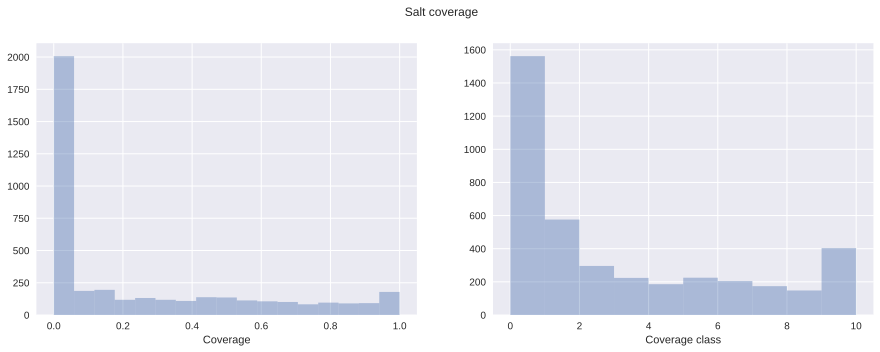

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

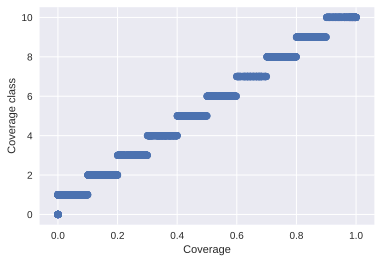

In [43]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

Text(0.5,1,'Depth distribution')

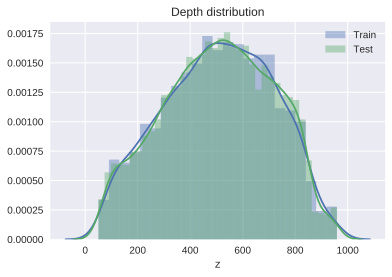

In [44]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

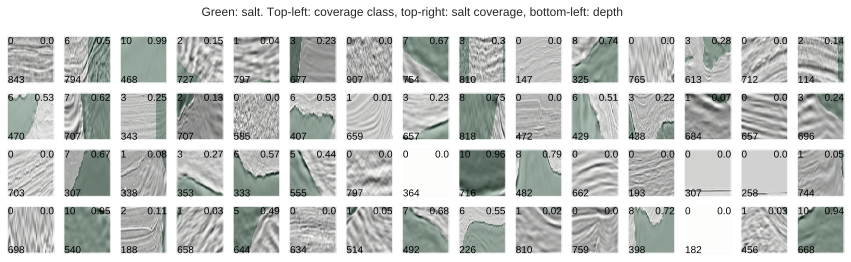

In [46]:
# Show some image examples
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.5, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [23]:
# we exclude all data whose coverage is less than 1.5% but not fully empty
# this method can improve the training accuracy, but may not be good in all conditions
train_df_notempty = train_df[(train_df.coverage > 0.015) | (train_df.coverage == 0)]
print(len(train_df_notempty))

3780


In [0]:
# Split data into train and test sets stratified by salt coverage
x_train, x_valid, y_train, y_valid= train_test_split(
    np.array(train_df_notempty.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df_notempty.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    test_size=0.2, stratify=train_df_notempty.coverage_class, random_state=1337)

# Oooops, do not forget data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [0]:
def batch_activate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = batch_activate(x)
    return x

def residual_block(blockInput, num_filters=16, activation = False):
    x = batch_activate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if activation:
        x = batch_activate(x)
    return x

In [0]:
# Build model
# Unet with residual block
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch] > 0, B[batch] > 0
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 ) / (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)

In [0]:
# Code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        # elu doesn't perform better
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss")
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    logits = y_pred
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [0]:
# Model for the first stage
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)

model_pre = Model(input_layer, output_layer)

# If we use TPU
if USE_TPU:
  model_pre = tf.contrib.tpu.keras_to_tpu_model(
      model_pre,
      strategy=tf.contrib.tpu.TPUDistributionStrategy(
          tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
      )
  )

model_pre.compile(loss="binary_crossentropy", optimizer='adam', metrics=[my_iou_metric])

In [30]:
model_pre_name = MODEL_BASE_NAME + '_pre.model'

early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode='max',
                               patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(model_pre_name, monitor='val_my_iou_metric', 
                                   mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5,
                              patience=5, min_lr=0.0001, verbose=1)

epochs = 5
batch_size = 32
history = model_pre.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                        verbose=2)

Train on 6048 samples, validate on 756 samples
Epoch 1/5

Epoch 00001: val_my_iou_metric improved from -inf to 0.17130, saving model to res_Unet_V3_pre.model
 - 108s - loss: 14.1282 - my_iou_metric: 0.3327 - val_loss: 68.3621 - val_my_iou_metric: 0.1713
Epoch 2/5

Epoch 00002: val_my_iou_metric did not improve from 0.17130
 - 82s - loss: 9.6998 - my_iou_metric: 0.5318 - val_loss: 56.6181 - val_my_iou_metric: 0.1571
Epoch 3/5

Epoch 00003: val_my_iou_metric improved from 0.17130 to 0.40317, saving model to res_Unet_V3_pre.model
 - 82s - loss: 8.8840 - my_iou_metric: 0.5419 - val_loss: 20.7349 - val_my_iou_metric: 0.4032
Epoch 4/5

Epoch 00004: val_my_iou_metric did not improve from 0.40317
 - 82s - loss: 8.0672 - my_iou_metric: 0.5757 - val_loss: 12.1707 - val_my_iou_metric: 0.3107
Epoch 5/5

Epoch 00005: val_my_iou_metric improved from 0.40317 to 0.58214, saving model to res_Unet_V3_pre.model
 - 83s - loss: 7.3299 - my_iou_metric: 0.6136 - val_loss: 7.5868 - val_my_iou_metric: 0.5821


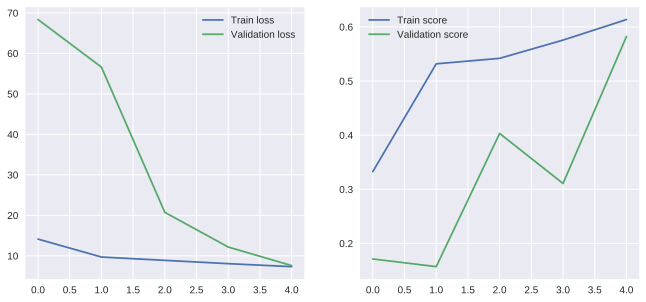

In [32]:
# Show the history of pre-training
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(11,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

In [0]:
# Split data into train and test sets stratified by salt coverage
# This time we add all data back
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_valid, depth_train, depth_valid = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [0]:
model_pre = load_model(model_pre_name, custom_objects={'my_iou_metric': my_iou_metric})
# Remove layter activation layer and use losvasz loss
input_x = model_pre.layers[0].input
output_layer = model_pre.layers[-1].input

# Build the final predict model
model = Model(input_x, output_layer)

# Lovasz loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer='adam', metrics=[my_iou_metric_2])

In [47]:
model_name = MODEL_BASE_NAME + '.model'

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max',
                               patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(model_name, monitor='val_my_iou_metric_2', 
                                   mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',
                              factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 5
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/5

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.57388, saving model to res_Unet_V3.model
 - 243s - loss: 0.7097 - my_iou_metric_2: 0.6391 - val_loss: 0.8102 - val_my_iou_metric_2: 0.5739
Epoch 2/5

Epoch 00002: val_my_iou_metric_2 did not improve from 0.57388
 - 191s - loss: 0.6771 - my_iou_metric_2: 0.6340 - val_loss: 0.8063 - val_my_iou_metric_2: 0.5557
Epoch 3/5

Epoch 00003: val_my_iou_metric_2 improved from 0.57388 to 0.64375, saving model to res_Unet_V3.model
 - 192s - loss: 0.6736 - my_iou_metric_2: 0.6313 - val_loss: 0.6549 - val_my_iou_metric_2: 0.6438
Epoch 4/5

Epoch 00004: val_my_iou_metric_2 improved from 0.64375 to 0.65550, saving model to res_Unet_V3.model
 - 192s - loss: 0.6379 - my_iou_metric_2: 0.6489 - val_loss: 0.6147 - val_my_iou_metric_2: 0.6555
Epoch 5/5

Epoch 00005: val_my_iou_metric_2 did not improve from 0.65550
 - 191s - loss: 0.6593 - my_iou_metric_2: 0.6326 - val_loss: 1.0572 - val_my_iou_m

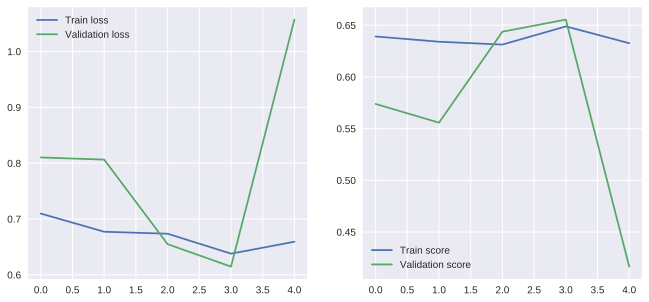

In [49]:
# Show history of final training round
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(11,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [0]:
model = load_model(model_name, custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                               'lovasz_loss': lovasz_loss})

In [0]:
def predict_result(model, x_test): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [0]:
preds_valid = predict_result(model, x_valid)

In [0]:
# Predict the validation set to do a sanity check
preds_valid_ori = preds_valid.reshape(-1, img_size_target, img_size_target)
preds_valid_ori = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

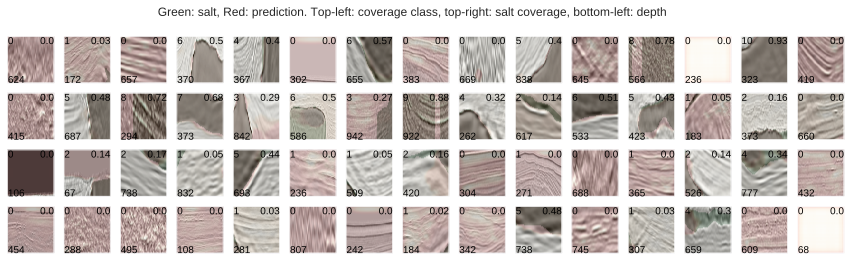

In [57]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid_ori[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.5, cmap="Greens")
    ax.imshow(pred, alpha=0.4, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [0]:
# Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

ious = np.array([get_iou_vector(y_valid, preds_valid.reshape(-1, img_size_target, img_size_target, 1) > threshold) for threshold in tqdm(thresholds)])
print('Finding best threshold...\n', ious)

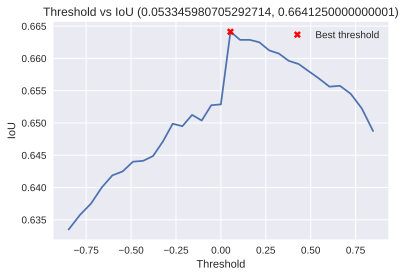

In [61]:
# Instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "Xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

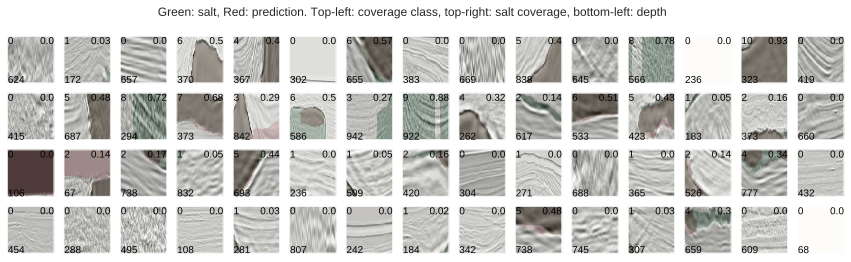

In [63]:
# Another sanity check with adjusted threshold
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid_ori[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.5, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.4, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [0]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [0]:
x_test = np.array([upsample(np.array(load_img("./data/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [0]:
preds_test = model.predict(x_test)

In [0]:
# Test time augmention
x_test2 = np.array([np.fliplr(x) for x in x_test])
preds_test2 = model.predict(x_test2)
preds_test2 = np.array([np.fliplr(x) for x in preds_test2])
preds_test = (preds_test + preds_test2) / 2

In [0]:
# Prepare for submission
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')